In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install bertopic
!pip install "tensorflow>=2.0.0"
!pip install --upgrade tensorflow-hub
!pip install tensorflow-text
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 79.9 MB/s 
     |████████████████████████████████| 7.6 MB 75.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.1 MB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 5.2 MB 61.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 662 kB 72.5 MB/s 
     |████████████████████████████████| 1.3 MB 69.0 MB/s 
     |████████████████████████████████| 1.1 MB 84.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700824 sha256=665

In [ ]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import requests
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch
from torch import nn  
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro
from bertopic import BERTopic
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
import tensorflow_addons as tfa
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Data preparation

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_without_labels.csv')

le = LabelEncoder()
df_train['Label'] = le.fit_transform(df_train['Label'])

Diagram to see wich class has the most examples

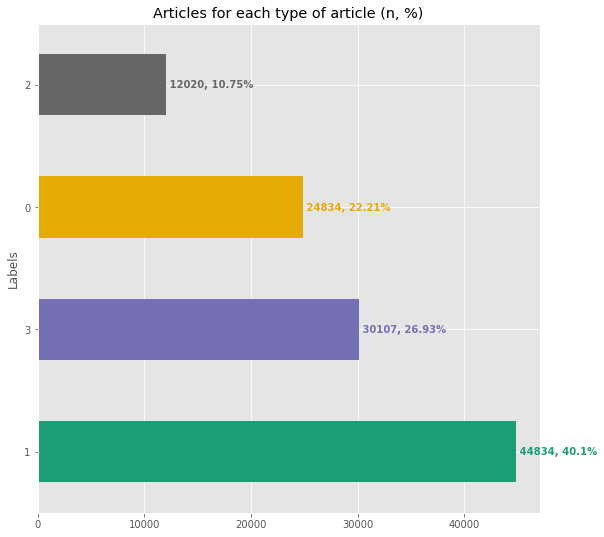

In [ ]:
plt.style.use('ggplot')
num_classes = len(df_train["Label"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df_train['Label'].value_counts().plot.barh(title="Articles for each type of article (n, %)", 
                                                 ylabel="Labels",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df_train['Label'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df_train.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

Transform the data of our target column to numerical and split our data to train and test sets

In [ ]:
y = tf.keras.utils.to_categorical(df_train["Label"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df_train['Content'], y, test_size=0.6) # https://stats.stackexchange.com/questions/59630/test-accuracy-higher-than-training-how-to-interpret

Load Bert with tensorflow hub

In [ ]:

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


As we are facing a multi-class classification problem, and we previously noticed that our topics distribution is  imbalanced, we might want to observe different metrics during model training.

For this reason, we define functions to calculate, respectively, precision, recall, and F1 score for each class during training, and then return the average value over the classes:

In [ ]:


def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


We now define a model as the preprocessor and encoder layers followed by a dropout and a dense layer with a softmax activation function and an output space dimensionality equal to the number of classes we want to predict

In [ ]:

i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


We train out model with the **Content** feature first.

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/5
1398/1398 [==============================] - 1236s 870ms/step - loss: 0.4058 - accuracy: 0.8597 - balanced_recall: 0.7673 - balanced_precision: 0.8650 - balanced_f1_score: 0.8092 - val_loss: 0.2772 - val_accuracy: 0.9032 - val_balanced_recall: 0.8559 - val_balanced_precision: 0.9095 - val_balanced_f1_score: 0.8809
Epoch 2/5
1398/1398 [==============================] - 1202s 860ms/step - loss: 0.2818 - accuracy: 0.8986 - balanced_recall: 0.8615 - balanced_precision: 0.9007 - balanced_f1_score: 0.8798 - val_loss: 0.2582 - val_accuracy: 0.9059 - val_balanced_recall: 0.8692 - val_balanced_precision: 0.9090 - val_balanced_f1_score: 0.8879
Epoch 3/5
1398/1398 [==============================] - 1202s 860ms/step - loss: 0.2715 - accuracy: 0.9024 - balanced_recall: 0.8688 - balanced_precision: 0.9023 - balanced_f1_score: 0.8844 - val_loss: 0.2439 - val_accuracy: 0.9134 - val_balanced_recall: 0.8820 - val_balanced_precision: 0.9131 - val_balanced_f1_score: 0.8966
Epoch 4/5
1398/1398 [=

Plot the values assumed by each monitored metric during the training procedure, and compare the training and validation curves:

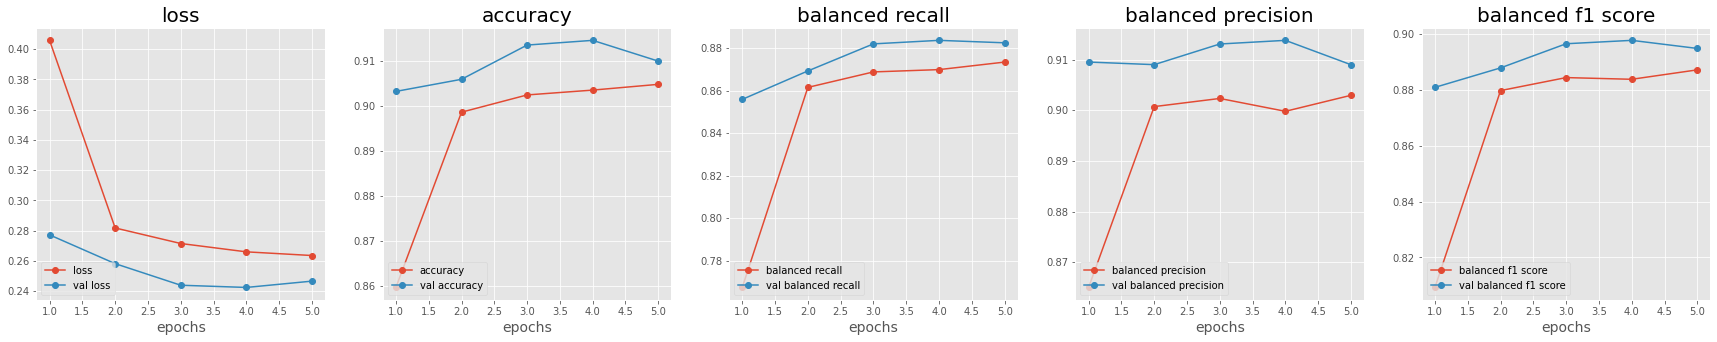

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

we can simply take the index associated to the higher probability (np.argmax) to infer the predicted label

In [ ]:
def predict_class(articles):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(articles)]


#predict_class(df_test['Content'])

Experiment with the **Title** feature

Epoch 1/5
2621/2621 [==============================] - 1147s 436ms/step - loss: 0.3824 - accuracy: 0.8611 - balanced_recall: 0.8169 - balanced_precision: 0.8582 - balanced_f1_score: 0.8360 - val_loss: 0.3364 - val_accuracy: 0.8782 - val_balanced_recall: 0.8324 - val_balanced_precision: 0.8819 - val_balanced_f1_score: 0.8554
Epoch 2/5
2621/2621 [==============================] - 1136s 433ms/step - loss: 0.3655 - accuracy: 0.8676 - balanced_recall: 0.8248 - balanced_precision: 0.8657 - balanced_f1_score: 0.8437 - val_loss: 0.3357 - val_accuracy: 0.8780 - val_balanced_recall: 0.8315 - val_balanced_precision: 0.8819 - val_balanced_f1_score: 0.8549
Epoch 3/5
2621/2621 [==============================] - 1136s 433ms/step - loss: 0.3589 - accuracy: 0.8688 - balanced_recall: 0.8282 - balanced_precision: 0.8679 - balanced_f1_score: 0.8466 - val_loss: 0.3313 - val_accuracy: 0.8793 - val_balanced_recall: 0.8355 - val_balanced_precision: 0.8817 - val_balanced_f1_score: 0.8570
Epoch 4/5
2621/2621 [=

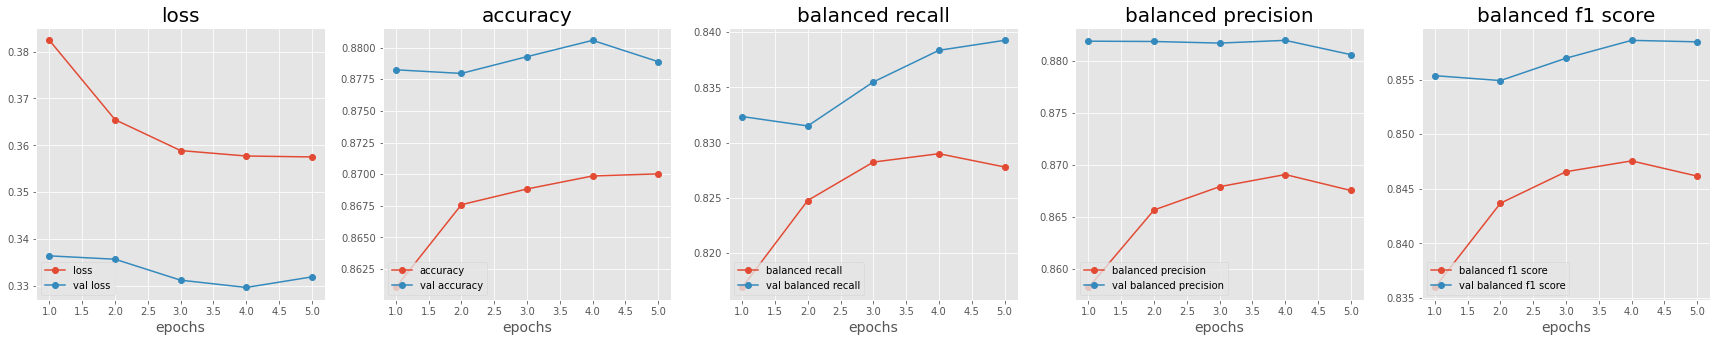

In [ ]:
y = tf.keras.utils.to_categorical(df_train["Label"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df_train['Title'], y, test_size=0.25)

n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

#print(predict_class(df_test['Title']))

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

1498/1498 [==============================] - 95s 63ms/step
[1, 3, 1, 1, 1, 0, 3, 2, 3, 2, 3, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 0, 1, 3, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 0, 3, 0, 1, 0, 0, 1, 1, 1, 1, 2, 3, 0, 1, 3, 0, 2, 0, 2, 1, 1, 3, 3, 0, 2, 3, 0, 1, 0, 3, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 3, 3, 1, 1, 3, 1, 1, 0, 1, 3, 0, 1, 0, 1, 1, 3, 0, 1, 0, 1, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 0, 1, 0, 3, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 1, 0, 2, 1, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3, 0, 0, 1, 1, 2, 0, 1, 3, 0, 2, 1, 2, 0, 3, 0, 1, 3, 0, 2, 3, 3, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 2, 0, 3, 1, 1, 3, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 3, 0, 0, 1, 0, 0, 0, 1, 1, 3, 0, 1, 1, 1, 3, 2, 0, 1, 3, 0, 1, 3, 0, 0, 2, 1, 3, 1, 1, 2, 1, 3, 0, 1, 3, 1, 0, 1, 3, 0, 3, 2, 1, 1, 1, 3, 0, 3, 3, 0, 1, 1, 1, 1, 2, 3, 1, 3, 1, 0, 1, 3, 3, 1, 2, 1, 0, 1, 1, 1, 1, 2, 3, 3, 1

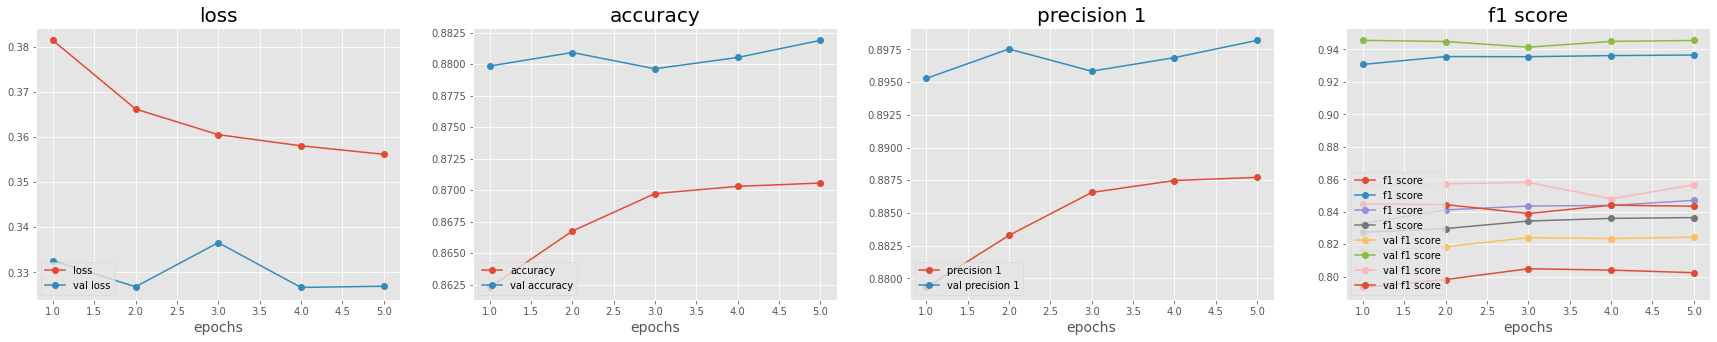

In [ ]:
print(predict_class(df_test['Title']))

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

# **LSTM**

**LSTM Modeling**
- Vectorize article text, by turning each text into either a sequence of integers or into a vector.
-Limit the data set to the top 5,0000 words.
-Set the max number of words in each article at 500.

In [ ]:


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each article.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['Content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 366329 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling.

In [ ]:
X = tokenizer.texts_to_sequences(df_train['Content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (111795, 500)


Train test split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,df_train['Label'], test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(74902, 500) (74902,)
(36893, 500) (36893,)
31534    1
30258    1
57643    3
44446    0
3733     1
        ..
65111    0
43187    2
61230    0
95054    1
16164    2
Name: Label, Length: 36893, dtype: int64


- The first layer is the embedded layer that uses 100 length vectors to represent each word.

- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units

- The output layer must create 4 output values, one for each class.

- Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [ ]:
model = Sequential()
print(X.shape[1])
print(X_train.shape, Y_train.shape)
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

500
(74902, 500) (74902,)
Epoch 1/5
1054/1054 [==============================] - 1585s 2s/step - loss: 0.0000e+00 - accuracy: 0.3992 - val_loss: 0.0000e+00 - val_accuracy: 0.4120
Epoch 2/5
1054/1054 [==============================] - 1509s 1s/step - loss: 0.0000e+00 - accuracy: 0.3992 - val_loss: 0.0000e+00 - val_accuracy: 0.4120
Epoch 3/5
1054/1054 [==============================] - 1489s 1s/step - loss: 0.0000e+00 - accuracy: 0.3992 - val_loss: 0.0000e+00 - val_accuracy: 0.4120
Epoch 4/5
1054/1054 [==============================] - 1469s 1s/step - loss: 0.0000e+00 - accuracy: 0.3992 - val_loss: 0.0000e+00 - val_accuracy: 0.4120


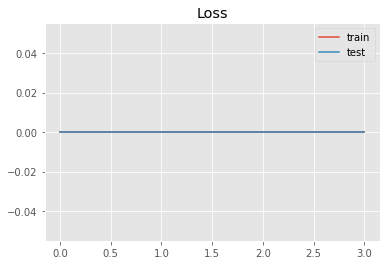

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

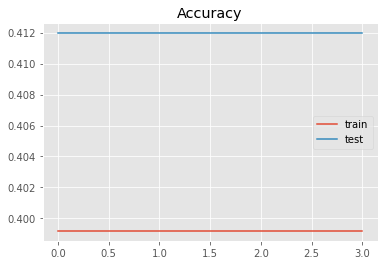

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();